In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def vec_det(mat):
    '''
    Compute determinant transforming mat in a triangular matrix
    '''
    if mat.shape[0] != mat.shape[1]: raise TypeError('Matrix not square')
    elif (mat == 0).all(axis=0).any() or (mat == 0).all(axis=1).any(): return 0
        
    mx = np.copy(mat).astype('float64') # necessary to force float division with int arrays! or .astype('float64')
    d = 1
    
    for i in range(mx.shape[0]-1):
        
        if (mx[i:, i] == 0).all(): return 0
        elif (mx[i+1, i] == 0).all(): continue
    
        ind = np.arange(i, mx.shape[0])[mx[i:, i] != 0][0]
        
        if ind != i:
            d = -d
            newOrd = [*range(mx.shape[0])]
            newOrd[ind], newOrd[i] = i, ind
            mx = mx[newOrd]

        d /= mx[i, i]
        mx[i] = mx[i] / mx[i, i]
        mx[(i+1):] = mx[(i+1):] - mx[(i+1):, i][:, np.newaxis]*mx[i]

    return np.multiply.reduce(np.diag(mx)) / d

### Characteristic polynomial: 
https://textbooks.math.gatech.edu/ila/characteristic-polynomial.html

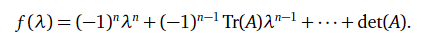

In [3]:
def char_coeff(mat):
    '''
    Return coefficients of characteristic polynomial, ordered from
    lower to higher degree
    '''
    Tr = np.diag(mat).sum() # trace 
    res = np.array([vec_det(mat)])
    
    for i in range(mat.shape[0]-1, 0, -1):
        res = np.append(res, (-1)**(mat.shape[0] - i)*Tr)
    
    res = np.append(res, (-1)**(mat.shape[0])) 
    return res

In [4]:
arr = np.array([[5, 2], [2, 1]])
A = np.array([[ 3,  2,  1,  2], [ 7,  5,  2,  5], [ 0,  0,  9,  4], [ 0,  0, 11,  5]])
b = np.array(np.random.randint(1, 101, 100)).reshape((10,10))

In [5]:
char_coeff(arr)

array([ 1., -6.,  1.])

In [6]:
char_coeff(A)

array([  1., -22.,  22., -22.,   1.])

In [7]:
char_coeff(b)

array([ 5.94353998e+17, -3.67000000e+02,  3.67000000e+02, -3.67000000e+02,
        3.67000000e+02, -3.67000000e+02,  3.67000000e+02, -3.67000000e+02,
        3.67000000e+02, -3.67000000e+02,  1.00000000e+00])

In [8]:
def y_for_x(coeff, x):
    '''
    Return y value for given x in polynomial with coeff ordered from lower to higher 
    (operates both with single values or arrays)
    '''
    y = 0
    for i in range(len(coeff)):
        y += coeff[i]*x**i
    return y

In [9]:
def char_polynomial(mat, xmin=-10, xmax=10, steps=200):
    '''
    Return characteristic polynomial values from xmin to xmax in steps
    '''   
    x = np.linspace(xmin, xmax, steps)
    y = y_for_x(char_coeff(mat), x)

    return x, y

In [10]:
x1, y1 = char_polynomial(A)

In [11]:
x1[:20]

array([-10.        ,  -9.89949749,  -9.79899497,  -9.69849246,
        -9.59798995,  -9.49748744,  -9.39698492,  -9.29648241,
        -9.1959799 ,  -9.09547739,  -8.99497487,  -8.89447236,
        -8.79396985,  -8.69346734,  -8.59296482,  -8.49246231,
        -8.3919598 ,  -8.29145729,  -8.19095477,  -8.09045226])

In [12]:
y1[:20]

array([34421.        , 33322.12753663, 32248.77720124, 31200.57503048,
       30177.14950959, 29178.13157243, 28203.15460145, 27251.85442772,
       26323.86933091, 25418.8400393 , 24536.40972977, 23676.2240278 ,
       22837.9310075 , 22021.18119157, 21225.6275513 , 20450.92550663,
       19696.73292605, 18962.71012671, 18248.51987432, 17553.82738324])

In [13]:
def char_plot(mat, figsize=(7,5), *args, **kwargs):
    '''
    Plot char_polynomial with passed args and kwargs and return fig, ax
    '''
    fig, ax = plt.subplots(figsize=figsize)
    data = char_polynomial(mat, *args, **kwargs)
    
    ax.plot(*data)
    ax.hlines(y=0, xmin=min(data[0]), xmax=max(data[0]), color='gray', alpha=0.2)
    ax.vlines(x=0, ymin=min(data[1]), ymax=max(data[1]), color='gray', alpha=0.2)
    
    return fig, ax

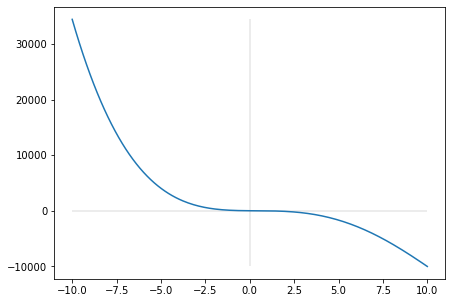

In [14]:
fig, ax = char_plot(A)

In [15]:
def deriv_coeff(coeff):
    '''
    Calculate first derivative coefficients of a polynomial 
    whose passed coeff are ordered from lower to higher
    '''
    der_coeff = np.array([])
    for i in range(1, len(coeff)):
        der_coeff = np.append(der_coeff, coeff[i]*i)
    
    return der_coeff

In [16]:
%timeit deriv_coeff(char_coeff(b))
deriv_coeff(char_coeff(b))

569 µs ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([ -367.,   734., -1101.,  1468., -1835.,  2202., -2569.,  2936.,
       -3303.,    10.])

In [17]:
deriv_coeff(char_coeff(A))

array([-22.,  44., -66.,   4.])

In [18]:
y1[(-0.5 < y1) & (y1 < 0.5)] # values of y1 that are near to zero

array([-0.05275877])

In [19]:
x1[(-0.5 < y1) & (y1 < 0.5)] # correspondent x values (candidate solutions)

array([0.05025126])

The above values can be used to make first guesses in Newton method:

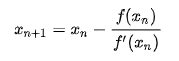

where x is guess, f(x) is polynomial equation and f'(x) its first derivative.

In [20]:
def newton_eig(mat, guess=np.random.randint(-10, 10, 1), attempts=100, error=0):
    '''
    From a random guess, execute n attempts with Newton method
    '''
    charCoeff  = char_coeff(mat)
    derivCoeff = deriv_coeff(charCoeff)
    
    while attempts > 0 or (-error < y_for_x(charCoeff, guess) < error):
        guess = guess - (y_for_x(charCoeff, guess) / y_for_x(derivCoeff, guess))
        attempts -= 1
        
    return guess, y_for_x(charCoeff, guess) # i.e. x and y of solution

In [21]:
newton_eig(A)

(array([0.04761392]), array([5.27786229e-18]))

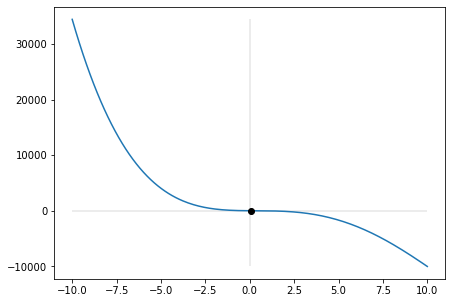

In [22]:
ax.plot(*newton_eig(A), 'ko')
fig

But using y values (-err < 0 < err) is risky, because if x values are not sufficiently dense the y values nearest to 0 could be very distant in absolute term. So let's define a function that finds eigenvalues with Newton method but using more intelligent initial guesses.

In [23]:
def all_newton(mat, xmin=-1000, xmax=1000, steps=2000, attempts=100, error=0):
    '''
    Compute an eigenval beginning from every y sign change.
    1) attempts and error are passed to newton_eig
    2) xmin, xmax, steps are passed to char_polynomial
    '''
    x, y = char_polynomial(mat, xmin, xmax, steps) 
    
    guesses = np.append(x[:-1][(y[:-1] > 0)&(y[1:] < 0)],  # values of x when next y value become negative 
                        x[:-1][(y[:-1] < 0)&(y[1:] > 0)])  # values of x when next y value becomes positive
     
    eigvals  = set() # so values are not duplicated
    
    for i in guesses:
        eigvals.add(newton_eig(mat, i, attempts, error))
        
    return tuple(eigvals)
# every value of eigenval is tuple of (eigenval, correspondent y values) 
# i.e. determinants of mat multiplied for correspondent eigenval diag matrix. The nearer to 0, the better the solution

`all_newton()`: 
 default values of xmin, xmax, steps = -1000, 1000, 2000
    
            because it is not necessary to have dense values:
            use sign inversions as guesses is a solution for discrete problem! 
            Even if y values computed are not near to 0, we can easily find were 
            the curve intersecates x axis. So better have a wide values' range 
            (values are successively refined by newton_eig) than dense values: 
            we can catch more guesses and hopefully more eigenvalues.

In [24]:
f'eigenvalues solutions: {all_newton(A)[0]}'

'eigenvalues solutions: (21.002261701524443, 0.0)'

In [25]:
f'correspondent determinants (measure of solution goodness): {all_newton(A)[1]}'

'correspondent determinants (measure of solution goodness): (0.04761391959645098, 5.2778622943415454e-18)'

In [26]:
M = np.hstack([A + A[0], A])
M = np.vstack([M, M + M[[*range(M.shape[0]-1, -1, -1)]]])
print(M)

[[ 6  4  2  4  3  2  1  2]
 [10  7  3  7  7  5  2  5]
 [ 3  2 10  6  0  0  9  4]
 [ 3  2 12  7  0  0 11  5]
 [ 9  6 14 11  3  2 12  7]
 [13  9 13 13  7  5 11  9]
 [13  9 13 13  7  5 11  9]
 [ 9  6 14 11  3  2 12  7]]


(<Figure size 504x360 with 1 Axes>, <AxesSubplot:>)

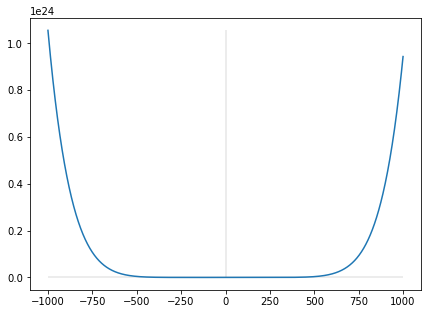

In [27]:
# characteristic polynomial of M
char_plot(M, xmin=-1000, xmax=1000, steps=2000)

In [28]:
# find nontrivial solution to characteristic polynomial of M
all_newton(M, xmin=-1000, xmax=1000, steps=2000)

((55.000000000036785, -0.015625), (0.0, 0.0))

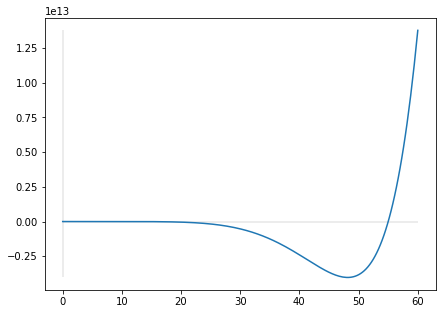

In [29]:
# Actually a smaller scale figure reveal an intersection with x axis:
fig2, ax2 = char_plot(M, xmin=0, xmax=60)

In [30]:
derivM = y_for_x(deriv_coeff(M), np.linspace(-1000, 1000, 200))

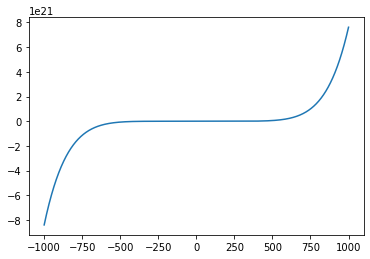

In [31]:
# plot first derivative of characteristic polynomial of M to check where its inclination changes 

axis = np.linspace(-1000, 1000, 2000)
derivM = y_for_x(deriv_coeff(char_coeff(M)), axis)
fig3, ax3 = plt.subplots()
ax3.plot(axis, derivM)

In [32]:
# x values before and after inversion of curve 

print(axis[:-1][(derivM[:-1] < 0)&(derivM[1:] > 0)],
      axis[1: ][(derivM[:-1] < 0)&(derivM[1:] > 0)])

[47.52376188] [48.52426213]


In [33]:
# determinate flexion point more precisely (with a denser axis)

axisTmp = np.linspace(45, 50, 1000)
tmp     = y_for_x(deriv_coeff(char_coeff(M)), axisTmp)
before  = axisTmp[1:][(tmp[:-1] < 0)&(tmp[1:] > 0)]
after   = axisTmp[:-1][(tmp[:-1] < 0)&(tmp[1:] > 0)]
print(f'x value before inclination inversion: {before}',
      f'\nx value after inclination inversion: {after}', 
      f'\n\nmean: {(before + after)/2}')

x value before inclination inversion: [48.14314314] 
x value after inclination inversion: [48.13813814] 

mean: [48.14064064]


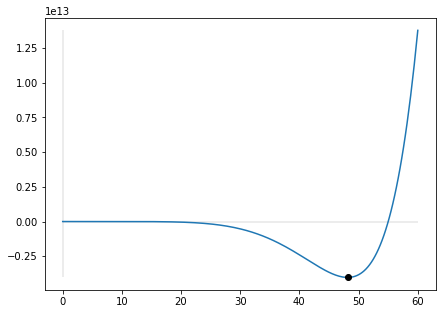

In [34]:
# plot point where char_polynomial of M changes inclination
ax2.plot((before+after)/2, y_for_x(char_coeff(M), (before+after)/2), 'ko')
fig2